<a href="https://colab.research.google.com/github/hmezer/eam-double-response/blob/main/files/simulator_debugger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install bayesflow tensorflow --quiet

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
#@title PRIOR
def sample_lca_prior():
    """
    Generates a single random draw from the joint prior distribution for LCA parameters.

    Returns:
    --------
    dict
        A dictionary containing a single sample for each LCA parameter.
    """
    # Drift rates (v_0, v_1): Normal(loc=0.0, scale=1.5)
    v_0 = np.random.normal(loc=0.0, scale=1.5)
    v_1 = np.random.normal(loc=0.0, scale=1.5)

    # Threshold (a): Uniform(low=0.5, high=2.5)
    a = np.random.uniform(low=0.5, high=2.5)

    # Non-decision time (ndt): Uniform(low=0.1, high=0.4)
    ndt = np.random.uniform(low=0.1, high=0.4)

    # Leakage rate (la): Uniform(low=0.0, high=0.5)
    la = np.random.uniform(low=0.0, high=0.5)

    # Lateral inhibition rate (ka): Uniform(low=0.0, high=0.5)
    ka = np.random.uniform(low=0.0, high=0.5)

    # Diffusion noise scale (s): Uniform(low=0.5, high=1.5)
    s = np.random.uniform(low=0.5, high=1.5)

    return {
        "v_0": v_0,
        "v_1": v_1,
        "a": a,
        "ndt": ndt,
        "la": la,
        "ka": ka,
        "s": s
    }


In [32]:
#@title LCA w/ accumulation path
# Line 1: Function definition with parameters
def lca_trial_extended(
    v_0,     # Drift rate for accumulator 0 (single float)
    v_1,     # Drift rate for accumulator 1 (single float)
    a,       # Decision threshold (single float)
    ndt,     # Non-decision time (single float)
    la,      # Leakage rate (single float)
    ka,      # Lateral inhibition rate (single float)
    s=1.0,   # Diffusion noise scale (single float), typically fixed or inferred
    dt=0.001,# Time step size (in seconds, float)
    max_sim_time=5.0, # Maximum total simulation time (in seconds, float)
    double_response_window=0.25 # Time window for detecting double responses (in seconds, float)
):
    """
    Simulates a single trial of a Leaky Competing Accumulator (LCA) model,
    extended to account for double responses, for exactly TWO alternatives.

    Instead of one accumulator moving between two boundaries, it uses two
    accumulators, each representing a choice option, competing with each other
    through inhibition and decaying via leakage, racing to hit a common threshold.

    Parameters:
    -----------
    v_0 : float
        Drift rate for decision alternative 0.
    v_1 : float
        Drift rate for decision alternative 1.
    a : float
        Decision threshold. Must be positive.
        (Analogous to DDM's 'a').
    ndt : float
        Non-decision time (in seconds). Must be non-negative.
        (Analogous to DDM's 'ter').
    la : float
        Leakage rate. Evidence decays towards zero. Must be non-negative. (NEW LCA parameter)
    ka : float
        Lateral inhibition rate. Accumulators inhibit each other. Must be non-negative. (NEW LCA parameter)
    s : float, optional
        Scale of the diffusion noise for each accumulator. Default is 1.0.
        (Analogous to DDM's 's').
    dt : float, optional
        Time step (in seconds) for the discrete simulation. Default is 0.001 (1 ms).
    max_sim_time : float, optional
        Maximum total simulation time (in seconds) to prevent infinite loops. Default is 5.0s.
    double_response_window : float, optional
        Time window (in seconds) after the initial response during which a second
        response is considered a 'double response'. Default is 0.25s (250ms).

    Returns:
    --------
    tuple: (initial_rt, initial_choice, has_double_response, double_rt_relative, double_choice)
        initial_rt : float
            The simulated initial response time (RT) for the trial (in seconds).
            Returns np.nan if max_sim_time is reached without an initial decision.
        initial_choice : int
            The index of the initially chosen alternative (0 or 1).
            Returns -1 if max_sim_time is reached without an initial decision.
        has_double_response : int
            1 if a double response occurred, 0 otherwise.
        double_rt_relative : float
            The time from the initial response to the double response (in seconds).
            np.nan if no double response.
        double_choice : int
            The index of the double response alternative (0 or 1).
            -1 if no double response.
    """
    # Line 40: Fixed number of alternatives for this specific LCA implementation
    num_alternatives = 2 # Fixed to 2
    # Line 41: Initialize accumulator evidence levels to zero
    x = np.zeros(num_alternatives) # Accumulator evidence for each alternative
    # Line 42: Combine individual drift rates (v_0, v_1) into an array 'v'
    v = np.array([v_0, v_1]) # Create array from individual drift rates
    # Line 43: Calculate the standard deviation of the noise term per time step
    # This scales the noise correctly for a Wiener process (diffusion process)
    noise_std = s * np.sqrt(dt)    # Correct scaling for Wiener process noise

    # Lines 45-58: Input validation
    # These lines check if the input parameters are within valid ranges (e.g., positive thresholds, non-negative times/rates).
    # If any parameter is invalid, the function immediately returns NaN/default values.
    # This is good practice for robustness, especially when sampling from priors that might occasionally generate extreme values.
    if a <= 0 or ndt < 0 or s <= 0 or dt <= 0:
        return {
            "init_rt": np.nan,
            "init_resp": -1,
            "dr_if": 0,
            "dr_rt": np.nan,
            "dr_resp": -1
        }
    if la < 0 or ka < 0: # Leakage and inhibition rates must be non-negative
        return {
            "init_rt": np.nan,
            "init_resp": -1,
            "dr_if": 0,
            "dr_rt": np.nan,
            "dr_resp": -1
        }

    # Line 60: Initialize iteration counter (time steps)
    num_iter = 0
    # Line 61: Calculate maximum number of iterations based on max_sim_time and dt
    max_iter = int(max_sim_time / dt)

    # Line 63-64: Initialize variables to store results of the initial response
    initial_rt_acc = np.nan # Accumulation time for initial response
    initial_choice = -1

    # Line 66-67: DEBUGGING - This line initializes an array to store the full accumulation paths.
    # This is typically used for plotting or detailed analysis of trajectories, not for standard inference.
    # It adds overhead and can be removed for production inference runs.
    x_store = np.zeros((max_iter, num_alternatives))

    # --- Phase 1: Accumulation for Initial Response ---
    # Line 70: Main simulation loop for the first response.
    # Continues as long as no accumulator has reached the threshold ('a') AND
    # the maximum number of iterations ('max_iter') has not been exceeded.
    while np.all(x < a) and num_iter < max_iter:
        # Line 71: Generate independent random noise for each accumulator for the current time step.
        noise = np.random.randn(num_alternatives) * noise_std
        # Line 72: Calculate the sum of evidence across all accumulators.
        # This is used for the lateral inhibition term.
        sum_x_others = np.sum(x)

        # Line 74: Loop through each accumulator to update its evidence
        for i in range(num_alternatives):
            # Line 76: Calculate the lateral inhibition term for the current accumulator 'i'.
            # It's the lateral inhibition rate 'ka' multiplied by the sum of evidence in *other* accumulators.
            inhibition_term = ka * (sum_x_others - x[i])

            # Line 80: Calculate the change in evidence (dx_i) for the current accumulator.
            # This is the core LCA equation:
            # dx = (drift - leakage*current_evidence - inhibition_from_others) * dt + noise
            dx_i = (v[i] - la * x[i] - inhibition_term) * dt + noise[i]

            # Line 81: Update the accumulator's evidence level.
            x[i] += dx_i

            # Line 84: Truncation at 0.
            # This ensures that evidence levels do not drop below zero. If an accumulator
            # falls below zero, its evidence is reset to zero. This is a common feature
            # of LCA models.
            x[i] = max(0.0, x[i])

            # Line 87-88: DEBUGGING - Stores the current evidence level for each accumulator at this time step.
            # Similar to x_store initialization, this is for detailed path analysis and can be removed for speed.
            x_store[num_iter, i] = x[i]

        # Line 90: Increment the time step counter.
        num_iter += 1

    # Lines 93-102: Check if an initial decision was made or if max_sim_time was reached.
    # If max_sim_time was reached without any accumulator hitting the threshold,
    # it means no decision was made, and NaN/default values are returned.
    if num_iter >= max_iter:
        return {
            "init_rt": np.nan,
            "init_resp": -1,
            "dr_if": 0,
            "dr_rt": np.nan,
            "dr_resp": -1,
            "x_store": x_store
        } # RT=NaN, no decision, no double response

    # Lines 105-106: If a decision was made, identify which accumulator crossed the threshold first.
    initial_choice = np.where(x >= a)[0][0]
    initial_rt_acc = num_iter * dt # Accumulation time for the first response

    # --- Phase 2: Continued Accumulation for Double Response ---
    # Lines 110-112: Initialize variables for double response tracking.
    has_double_response = 0
    double_rt_relative = np.nan
    double_choice = -1

    # Line 115: Calculate the absolute time when the double response detection window ends.
    # This is initial_rt_acc (time of first response) + double_response_window (e.g., 250 ms).
    double_response_end_time_abs = initial_rt_acc + double_response_window

    # Line 118: Continue simulation within the double response window.
    # The loop runs as long as the current time is within the double response window
    # AND the total simulation time has not exceeded max_sim_time.
    while num_iter * dt < double_response_end_time_abs and num_iter < max_iter:
        # Lines 119-120: Generate noise and sum of others' evidence for the current time step.
        noise = np.random.randn(num_alternatives) * noise_std
        sum_x_others = np.sum(x)

        # Line 122: Loop through each accumulator to update its evidence.
        for i in range(num_alternatives):
            # Lines 123-126: Update accumulator evidence (same LCA dynamics as Phase 1).
            inhibition_term = ka * (sum_x_others - x[i])
            dx_i = (v[i] - la * x[i] - inhibition_term) * dt + noise[i]
            x[i] += dx_i
            x[i] = max(0.0, x[i])

            # DEBUGGING
            x_store[num_iter, i] = x[i]

            # Lines 129-133: Check for a double response.
            # A double response occurs if an accumulator *other than the initial choice*
            # crosses the threshold 'a'.
            if i != initial_choice and x[i] >= a:
                has_double_response = 1
                # Calculate the time of the double response relative to the initial response.
                double_rt_relative = (num_iter * dt) - initial_rt_acc
                double_choice = i # Record which alternative caused the double response
                break # Exit inner loop immediately if a double response is found

        # Lines 135-136: If a double response was found in the inner loop, exit the outer loop too.
        if has_double_response == 1:
            break

        # Line 138: Increment the overall time step counter.
        num_iter += 1

    # Line 141: Calculate the final initial response time by adding non-decision time.
    final_initial_rt = initial_rt_acc + ndt

    # Lines 143-150: Return the results as a dictionary.
    d = {
        "init_rt": final_initial_rt,
        "init_resp": initial_choice,
        "dr_if": has_double_response,
        "dr_rt": double_rt_relative,
        "dr_resp": double_choice,
        "x_store": x_store # DEBUGGING - This is the full accumulation path history
    }

    return d


### Functionalities Not Aligned with the Authors' Modeling Approach (and Recommendations):

1.  **`x_store` (Lines 66-67, 87-88, 149):**
    * **Functionality:** This part of the code initializes and populates an array (`x_store`) to record the evidence accumulation path for both accumulators at every single time step throughout the simulation. It's then returned as part of the output dictionary.
    * **Alignment Issue:** While extremely useful for **debugging and visualization** (e.g., plotting the trajectories as in Figure 1 of the paper), storing and returning `x_store` for every single simulated trial is **highly inefficient and unnecessary for BayesFlow training and inference.** BayesFlow learns from *summary statistics* of the data, not the raw accumulation paths. Returning this large array for millions of simulations will consume massive amounts of memory and slow down your simulator significantly.
    * **Recommendation:** **Remove `x_store`** from the `lca_trial_extended` function for your actual BayesFlow implementation. It should only return the `init_rt`, `init_resp`, `dr_if`, `dr_rt`, `dr_resp`.

2.  **Return Type for Invalid Parameters (Lines 45-58):**
    * **Functionality:** The function returns a dictionary with `np.nan` and `-1`/`0` values if input parameters are invalid (e.g., `a <= 0`, `ndt < 0`, `la < 0`, `ka < 0`).
    * **Alignment Issue:** This is generally good for robustness. However, for `njit` and `numpy` to work smoothly, it's often better if the return type is consistent. Returning a dictionary with mixed types (float, int, nan) can sometimes cause issues if not handled carefully by the calling `njit` function (`generate_lca_data_for_batch`).
    * **Recommendation:** Ensure that `generate_lca_data_for_batch` (the wrapper for `make_simulator`) explicitly handles these `np.nan` values and potentially converts them to a consistent numerical placeholder (like `0.0` or a specific error code) before computing summary statistics, as `np.nan` can propagate and cause issues in `np.mean`, `np.quantile`, etc., unless explicitly handled with `np.nanmean`, `np.nanquantile`. Your `compute_lca_summary_stats` already has some `np.nan` handling, which is good.

3.  **Fixed `num_alternatives = 2` (Line 40):**
    * **Functionality:** The model is hardcoded to simulate exactly two decision alternatives.
    * **Alignment Issue:** The Evans et al. (2020) paper focuses on 2AFC (two-alternative forced choice) tasks, so this is perfectly aligned with their context. However, general LCA models can handle more alternatives. For *your specific project*, this is fine.

4.  **`v = np.array([v_0, v_1])` (Line 42):**
    * **Functionality:** It takes `v_0` and `v_1` as separate float arguments and then combines them into a NumPy array `v` for internal use.
    * **Alignment Issue:** This is a stylistic choice. It's perfectly fine and necessary because BayesFlow's `make_simulator` (when using `generative_model` directly) will pass each parameter from the prior as a separate argument. Your `lca_trial_extended` then correctly reassembles them.

Overall, the `lca_trial_extended` function correctly implements the core dynamics of the LCA model with leakage, lateral inhibition, and the crucial double response mechanism. The main point of non-alignment (and inefficiency) for BayesFlow is the `x_store` variable, which should be removed for the actual training and inference runs.

***

In [ ]:
# prompt: run lca trial and plot the resulting data path

# Sample parameters from the prior
params = sample_lca_prior()

# Run a single trial simulation with path storage
trial_results = lca_trial_extended(**params, max_sim_time=5.0) # Use a reasonable max_sim_time

# Extract the accumulation paths
x_store = trial_results["x_store"]

# Get the number of time steps simulated
num_steps = x_store.shape[0]
time_steps = np.arange(num_steps) * 0.001 # Assuming dt=0.001

# Plot the accumulation paths
plt.figure(figsize=(10, 6))

# Plot paths for each accumulator
plt.plot(time_steps, x_store[:, 0], label=f'Accumulator 0 (v={params["v_0"]:.2f})')
plt.plot(time_steps, x_store[:, 1], label=f'Accumulator 1 (v={params["v_1"]:.2f})')

# Plot the decision threshold
plt.axhline(y=params["a"], color='r', linestyle='--', label=f'Threshold (a={params["a"]:.2f})')

# Plot non-decision time offset
plt.axvline(x=params["ndt"], color='gray', linestyle=':', label=f'Non-decision Time (ndt={params["ndt"]:.3f})')

# Mark the initial response point (adjusted by NDT)
initial_response_abs_time = trial_results["init_rt"]
initial_response_acc_time = initial_response_abs_time - params["ndt"]
if initial_response_acc_time >= 0: # Only plot if accumulation time was positive
    plt.scatter(initial_response_acc_time, params["a"], color='k', zorder=5, label=f'Initial Response (RT={initial_response_abs_time:.3f})')
    plt.axvline(x=initial_response_acc_time, color='k', linestyle=':', alpha=0.7)


# Mark the double response point if it occurred
if trial_results["dr_if"] == 1:
    double_response_abs_time = initial_response_abs_time + trial_results["dr_rt"]
    double_choice_level = x_store[int(double_response_abs_time / 0.001) -1, trial_results["dr_resp"]] # Get level just before crossing
    plt.scatter(double_response_abs_time, params["a"], color='m', zorder=5, label=f'Double Response (RT={double_response_abs_time:.3f})')
    plt.axvline(x=double_response_abs_time, color='m', linestyle=':', alpha=0.7)


plt.title("LCA Trial Accumulation Paths")
plt.xlabel("Time (s)")
plt.ylabel("Evidence Accumulation")
plt.ylim(bottom=-0.1) # Start y-axis slightly below zero
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("LCA Trial Results:")
print(f"Initial RT (incl NDT): {trial_results['init_rt']:.3f} s")
print(f"Initial Choice: {trial_results['init_resp']}")
print(f"Double Response Occurred: {'Yes' if trial_results['dr_if'] == 1 else 'No'}")
if trial_results['dr_if'] == 1:
    print(f"Double Response RT (relative): {trial_results['dr_rt']:.3f} s")
    print(f"Double Response Choice: {trial_results['dr_resp']}")

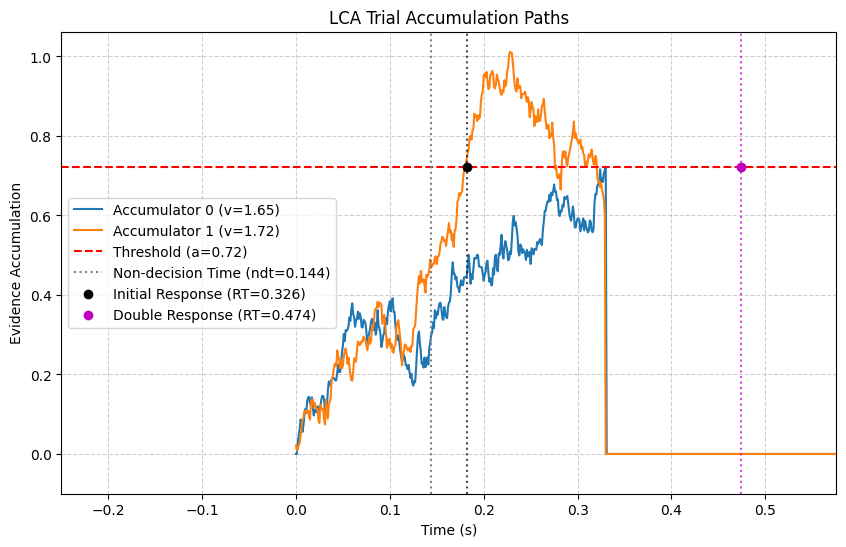

LCA Trial Results:
Initial RT (incl NDT): 0.326 s
Initial Choice: 1
Double Response Occurred: Yes
Double Response RT (relative): 0.148 s
Double Response Choice: 0


In [33]:
# prompt: run lca trial and plot the resulting data path

# Sample parameters from the prior
params = sample_lca_prior()

# Run a single trial simulation with path storage
trial_results = lca_trial_extended(**params, max_sim_time=5.0) # Use a reasonable max_sim_time

# Extract the accumulation paths
x_store = trial_results["x_store"]

# Get the number of time steps simulated
num_steps = x_store.shape[0]
time_steps = np.arange(num_steps) * 0.001 # Assuming dt=0.001

# Plot the accumulation paths
plt.figure(figsize=(10, 6))

# Plot paths for each accumulator
plt.plot(time_steps, x_store[:, 0], label=f'Accumulator 0 (v={params["v_0"]:.2f})')
plt.plot(time_steps, x_store[:, 1], label=f'Accumulator 1 (v={params["v_1"]:.2f})')

# Plot the decision threshold
plt.axhline(y=params["a"], color='r', linestyle='--', label=f'Threshold (a={params["a"]:.2f})')

# Plot non-decision time offset
plt.axvline(x=params["ndt"], color='gray', linestyle=':', label=f'Non-decision Time (ndt={params["ndt"]:.3f})')

# Mark the initial response point (adjusted by NDT)
initial_response_abs_time = trial_results["init_rt"]
initial_response_acc_time = initial_response_abs_time - params["ndt"]
if initial_response_acc_time >= 0: # Only plot if accumulation time was positive
    plt.scatter(initial_response_acc_time, params["a"], color='k', zorder=5, label=f'Initial Response (RT={initial_response_abs_time:.3f})')
    plt.axvline(x=initial_response_acc_time, color='k', linestyle=':', alpha=0.7)


# Mark the double response point if it occurred
if trial_results["dr_if"] == 1:
    double_response_abs_time = initial_response_abs_time + trial_results["dr_rt"]
    double_choice_level = x_store[int(double_response_abs_time / 0.001) -1, trial_results["dr_resp"]] # Get level just before crossing
    plt.scatter(double_response_abs_time, params["a"], color='m', zorder=5, label=f'Double Response (RT={double_response_abs_time:.3f})')
    plt.axvline(x=double_response_abs_time, color='m', linestyle=':', alpha=0.7)

# Determine the end time for plotting: initial response time + double response window
# Assuming the default double_response_window is 0.25s as in the function definition
plot_end_time = initial_response_abs_time + 0.25

plt.title("LCA Trial Accumulation Paths")
plt.xlabel("Time (s)")
plt.ylabel("Evidence Accumulation")
plt.ylim(bottom=-0.1) # Start y-axis slightly below zero
plt.xlim(right=plot_end_time) # Set the x-axis limit to include the double response window
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("LCA Trial Results:")
print(f"Initial RT (incl NDT): {trial_results['init_rt']:.3f} s")
print(f"Initial Choice: {trial_results['init_resp']}")
print(f"Double Response Occurred: {'Yes' if trial_results['dr_if'] == 1 else 'No'}")
if trial_results['dr_if'] == 1:
    print(f"Double Response RT (relative): {trial_results['dr_rt']:.3f} s")
    print(f"Double Response Choice: {trial_results['dr_resp']}")